## PyTorch autograd examples

In this example, we calculate transfer maps using PyTorch autograd Jacobian and compare times against numerical differentiation. We also calculate the gradient and the Hessian of the beamsize of a 10 quadrupole lattice with respect to the quadrupole strengths. 

In [1]:
import torch
import numpy as np

from bmadx import Particle, Drift, Quadrupole
from bmadx import track_element, track_lattice

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' # for high DPI displays in MacOS

torch.set_printoptions(precision= 8, sci_mode=True)

In [2]:
# Create torch particle beam

from bmadx import Particle, M_ELECTRON

s = 0.0 # initial s
p0c = 4e7 # reference momentum in eV

# Initial beam distribution
n_particles = 10_000 # number of particles in beam
coords = np.random.multivariate_normal(mean = np.zeros(6),
                                       cov = 1e-6*np.identity(6),
                                       size = n_particles
                                      )
beam_np = Particle(*coords.T, s=s, p0c=p0c, mc2=M_ELECTRON)

beam_torch = Particle(*torch.tensor(coords.T),
                      s=torch.tensor(s),
                      p0c=torch.tensor(p0c),
                      mc2=torch.tensor(M_ELECTRON))

In [3]:
# Tracking though element takes incoming particle coordinate
# type (i.e., torch tensor in this case) for the tracking regarldless
# the element parameter types.
q = Quadrupole(L=0.1, K1=10.0)
track_element(beam_torch, q)

Particle(x=tensor([-4.45677719e-04, 4.44459070e-04, -6.44109487e-04,  ..., -1.28037107e-03,
        2.84366105e-03, -3.83917434e-04], dtype=torch.float64), px=tensor([-2.44977111e-03, -1.73484396e-03,  1.56178082e-03,  ...,
        -8.63835896e-05, -1.64931144e-03, -1.75396379e-04],
       dtype=torch.float64), y=tensor([-5.46088639e-05,  1.13884843e-03, -1.22042103e-03,  ...,
         1.13439365e-03,  9.52307298e-04, -1.89289734e-03],
       dtype=torch.float64), py=tensor([5.79689316e-04, 2.95800948e-04, -3.55329798e-04,  ..., 1.44602444e-03,
        2.23911707e-03, -2.06573485e-03], dtype=torch.float64), z=tensor([-1.14955373e-04, -4.74741302e-04, -1.61562758e-05,  ...,
        -5.04109745e-04, -1.80247843e-04, -3.72884956e-04],
       dtype=torch.float64), pz=tensor([ 5.38909016e-05, -4.45496702e-04,  2.11823973e-03,  ...,
         9.12645340e-04, -5.15879887e-04,  1.53636242e-04],
       dtype=torch.float64), s=tensor(1.00000000e-01, dtype=torch.float64), p0c=tensor(4.00000000e+07

In [4]:
# we can use PyTorch autograd to calculate derivatives

# calculate Jacobian around 0 through quadrupole:
# define tracking as function of 6d coordinates:
f_quadrupole_torch = lambda coord: track_element(Particle(*coord,
                                                    s = torch.tensor(s),
                                                    p0c = torch.tensor(p0c),
                                                    mc2 = torch.tensor(M_ELECTRON)), 
                                                 q)[:6]
f_quadrupole_np = lambda coord: np.array(track_element(Particle(*coord,
                                                                s = s,
                                                                p0c = p0c,
                                                                mc2 = M_ELECTRON), 
                                                       q)[:6])

In [5]:
import torch.autograd.functional as ad

In [6]:
%%time
# Jacobian evaluated at 0 using pytorch autograd:
J_ad = ad.jacobian(f_quadrupole_torch, torch.zeros(6))
J_ad = torch.vstack(J_ad)
J_ad

CPU times: user 25.5 ms, sys: 2.08 ms, total: 27.5 ms
Wall time: 25.2 ms


tensor([[ 9.50415313e-01,  9.83416438e-02,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [-9.83416438e-01,  9.50415313e-01, -0.00000000e+00,  0.00000000e+00,
          0.00000000e+00, -0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.05041802e+00,  1.01675019e-01,
          0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00,  0.00000000e+00,  1.01675022e+00,  1.05041802e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00,  1.63173318e-05],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  1.00000000e+00]])

In [7]:
import numdifftools as nd

In [8]:
%%time
# Jacobian evaluated at 0 using numerical differentiation:
J_nd = nd.Jacobian(f_quadrupole_np)(np.zeros(6))
J_nd

CPU times: user 133 ms, sys: 7.63 ms, total: 141 ms
Wall time: 139 ms


/home/jg2347/Repositories/Bmad-X/bmadx/bmad/low_level/track_a_quadrupole.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  k1 = b1/(l*rel_p)
/home/jg2347/Repositories/Bmad-X/bmadx/bmad/low_level/quad_mat2_calc.py:28: RuntimeWarning: invalid value encountered in cos
  cx = cos(sk_l) * (k1<=0) + cosh(sk_l) * (k1>0)
/home/jg2347/Repositories/Bmad-X/bmadx/bmad/low_level/quad_mat2_calc.py:28: RuntimeWarning: invalid value encountered in multiply
  cx = cos(sk_l) * (k1<=0) + cosh(sk_l) * (k1>0)
/home/jg2347/Repositories/Bmad-X/bmadx/bmad/low_level/quad_mat2_calc.py:29: RuntimeWarning: invalid value encountered in sin
  sx = (sin(sk_l)/(sqrt_k))*(k1<=0) + (sinh(sk_l)/(sqrt_k))*(k1>0)
/home/jg2347/Repositories/Bmad-X/bmadx/bmad/low_level/quad_mat2_calc.py:29: RuntimeWarning: invalid value encountered in double_scalars
  sx = (sin(sk_l)/(sqrt_k))*(k1<=0) + (sinh(sk_l)/(sqrt_k))*(k1>0)


array([[ 9.50415280e-01,  9.83416469e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-9.83416469e-01,  9.50415280e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.05041806e+00,
         1.01675020e-01,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.01675020e+00,
         1.05041806e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  1.63173324e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [9]:
# calculate gradient of beamsize with respect to quadrupole strengths:

# fixed parameters:
half_drift = Drift(L=0.9/2) # half drift
L_q = 0.1 # quad length

def beamsize(beam_in, quad_strengths):
    """Function of beamsize with respect to quad strengths"""
    # create lattice of len(quad_strengths) quadrupoles separated by drifts:
    lattice = [] # initialize lattice
    for k1 in quad_strengths:
        lattice.append( half_drift )
        lattice.append( Quadrupole(L=L_q, K1=k1) )
        lattice.append( half_drift )
        
    beam_out = track_lattice(beam_in, lattice)
    return beam_out.x.std()

beamsize_torch = lambda k1s: beamsize(beam_torch, k1s)
beamsize_np = lambda k1s: beamsize(beam_np, k1s)

In [10]:
%%time
# calculate gradient of beamsize with respect to quad strengths using torch autograd:
grad_ad = ad.jacobian(beamsize_torch, torch.zeros(10))
grad_ad

CPU times: user 1.14 s, sys: 197 ms, total: 1.34 s
Wall time: 784 ms


tensor([-5.18615823e-04, -1.31526042e-03, -1.91036088e-03, -2.30391696e-03, -2.49592867e-03,
        -2.48639612e-03, -2.27531930e-03, -1.86269835e-03, -1.24853302e-03, -4.32823348e-04])

In [11]:
%%time
# calculate gradient of beamsize with respect to quad strengths using numerical diff:
grad_nd = nd.Jacobian(beamsize_np)(np.zeros(10))
grad_nd

CPU times: user 53.9 s, sys: 0 ns, total: 53.9 s
Wall time: 53.9 s


array([[-0.00056911, -0.00136572, -0.00196079, -0.00235433, -0.00254633,
        -0.0025368 , -0.00232573, -0.00191313, -0.00129899, -0.00048333]])

In [12]:
%%time
# calculate Hessian of beamsize with respect to quad strengths using torch autograd:
hes_ad = ad.hessian(beamsize_torch, torch.zeros(10))
hes_ad

CPU times: user 10.9 s, sys: 885 ms, total: 11.8 s
Wall time: 8.17 s


tensor([[7.96372988e-05, 1.05492698e-04, 1.27322579e-04, 1.39940588e-04,
         1.43346726e-04, 1.37540992e-04, 1.22523386e-04, 9.82939164e-05,
         6.48525674e-05, 2.21993523e-05],
        [1.05492698e-04, 5.10406644e-05, 1.44106656e-04, 2.20606729e-04,
         2.67387979e-04, 2.84450391e-04, 2.71793950e-04, 2.29418700e-04,
         1.57324612e-04, 5.55116785e-05],
        [1.27322579e-04, 1.44106656e-04, 3.09408715e-05, 1.72100103e-04,
         2.82176683e-04, 3.42066545e-04, 3.51769733e-04, 3.11286247e-04,
         2.20616042e-04, 7.97591492e-05],
        [1.39940588e-04, 2.20606729e-04, 1.72100103e-04, 1.74603647e-05,
         1.87712838e-04, 3.10389500e-04, 3.62450752e-04, 3.43896536e-04,
         2.54726881e-04, 9.49417736e-05],
        [1.43346726e-04, 2.67387979e-04, 2.82176683e-04, 1.87712838e-04,
         8.95623089e-06, 1.89419239e-04, 3.03836947e-04, 3.27249552e-04,
         2.59657099e-04, 1.01059537e-04],
        [1.37540992e-04, 2.84450391e-04, 3.42066545e-04, 3.1

In [13]:
%%time
# calculate Hessian of beamsize with respect to quad strengths using numerical diff:
hes_nd = nd.Hessian(beamsize_np)(np.zeros(10))
hes_nd

CPU times: user 9min 2s, sys: 69.7 ms, total: 9min 2s
Wall time: 9min 2s


array([[8.14521291e-05, 1.14610889e-04, 1.39448167e-04, 1.54066402e-04,
        1.58465593e-04, 1.52645741e-04, 1.36606845e-04, 1.10348906e-04,
        7.38719228e-05, 2.71758966e-05],
       [1.14610889e-04, 5.55111921e-05, 1.60180327e-04, 2.38677435e-04,
        2.86449560e-04, 3.03496704e-04, 2.89818865e-04, 2.45416045e-04,
        1.70288243e-04, 6.44354585e-05],
       [1.39448167e-04, 1.60180327e-04, 3.73949943e-05, 1.93114538e-04,
        3.04178821e-04, 3.64051289e-04, 3.72731940e-04, 3.30220776e-04,
        2.36517796e-04, 9.16229995e-05],
       [1.54066402e-04, 2.38677435e-04, 1.93114538e-04, 2.52260758e-05,
        2.11653377e-04, 3.34309496e-04, 3.85346069e-04, 3.64763098e-04,
        2.72560581e-04, 1.08738519e-04],
       [1.58465593e-04, 2.86449560e-04, 3.04178821e-04, 2.11653377e-04,
        1.73616041e-05, 2.14271324e-04, 3.27661252e-04, 3.49043011e-04,
        2.78416599e-04, 1.15782018e-04],
       [1.52645741e-04, 3.03496704e-04, 3.64051289e-04, 3.34309496e-04,
   

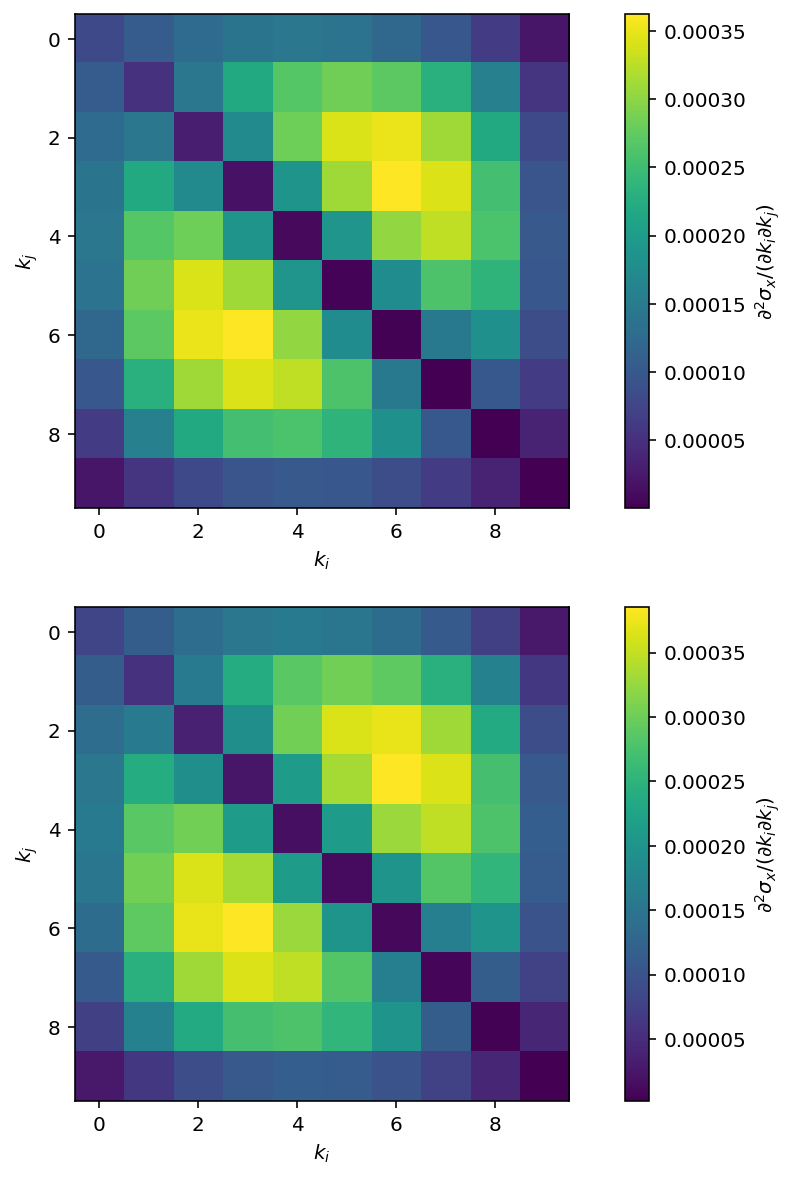

In [16]:
fig, axs = plt.subplots(2, figsize=(10,10))
cm = axs[0].imshow(hes_ad.detach().numpy())
axs[0].set_xlabel(r'$k_i$')
axs[0].set_ylabel(r'$k_j$')
fig.colorbar(cm,ax=axs[0], label=r'$\partial^2 \sigma_x / (\partial k_i \partial k_j)$')
cm = axs[1].imshow(hes_nd)
axs[1].set_xlabel(r'$k_i$')
axs[1].set_ylabel(r'$k_j$')
fig.colorbar(cm,ax=axs[1], label=r'$\partial^2 \sigma_x / (\partial k_i \partial k_j)$')